In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [2]:
import re

In [3]:
sentences = """There was nothing so very remarkable in that nor did Alice think it so _very_ much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually _took a watch out of its waistcoat-pocket_, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge."""

Clean Data

In [5]:
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)                  # remove special characters
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()      # remove 1 letter words
sentences = sentences.lower()                                        # lower all characters

Vocabulary

In [7]:
words = sentences.split()   # Split the cleaned sentences into words
vocab = set(words)          # Get the unique set of words/vocab

In [8]:
vocab

{'across',
 'actually',
 'after',
 'afterwards',
 'alice',
 'all',
 'and',
 'at',
 'be',
 'before',
 'burning',
 'but',
 'curiosity',
 'dear',
 'did',
 'down',
 'either',
 'feet',
 'field',
 'flashed',
 'for',
 'fortunately',
 'had',
 'have',
 'hear',
 'hedge',
 'her',
 'hole',
 'hurried',
 'in',
 'it',
 'its',
 'itself',
 'just',
 'large',
 'late',
 'looked',
 'mind',
 'much',
 'natural',
 'never',
 'nor',
 'nothing',
 'occurred',
 'of',
 'oh',
 'on',
 'or',
 'ought',
 'out',
 'over',
 'pocket',
 'pop',
 'quite',
 'rabbit',
 'ran',
 'remarkable',
 'say',
 'see',
 'seemed',
 'seen',
 'shall',
 'she',
 'so',
 'started',
 'take',
 'that',
 'the',
 'then',
 'there',
 'think',
 'this',
 'thought',
 'time',
 'to',
 'took',
 'under',
 'very',
 'waistcoat',
 'was',
 'watch',
 'way',
 'when',
 'with',
 'wondered'}

In [9]:
vocab_size = len(vocab)
embed_dim = 10               # words ahown in 10 dimention
context_size = 2             # 2 context word in front and back

Implementation

In [11]:
# map each word to a index number to represent in the 10 dim graph
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}  

Data bags

In [13]:
# data - [(context), target]
test_context = []
data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
    test_context.append(context)
print(data[:20])
print("\n=====================================================\n")
print(test_context[:20])

[(['there', 'was', 'so', 'very'], 'nothing'), (['was', 'nothing', 'very', 'remarkable'], 'so'), (['nothing', 'so', 'remarkable', 'in'], 'very'), (['so', 'very', 'in', 'that'], 'remarkable'), (['very', 'remarkable', 'that', 'nor'], 'in'), (['remarkable', 'in', 'nor', 'did'], 'that'), (['in', 'that', 'did', 'alice'], 'nor'), (['that', 'nor', 'alice', 'think'], 'did'), (['nor', 'did', 'think', 'it'], 'alice'), (['did', 'alice', 'it', 'so'], 'think'), (['alice', 'think', 'so', 'very'], 'it'), (['think', 'it', 'very', 'much'], 'so'), (['it', 'so', 'much', 'out'], 'very'), (['so', 'very', 'out', 'of'], 'much'), (['very', 'much', 'of', 'the'], 'out'), (['much', 'out', 'the', 'way'], 'of'), (['out', 'of', 'way', 'to'], 'the'), (['of', 'the', 'to', 'hear'], 'way'), (['the', 'way', 'hear', 'the'], 'to'), (['way', 'to', 'the', 'rabbit'], 'hear')]


[['there', 'was', 'so', 'very'], ['was', 'nothing', 'very', 'remarkable'], ['nothing', 'so', 'remarkable', 'in'], ['so', 'very', 'in', 'that'], ['very

Embeddings

In [15]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))    # Randomly putting all vocab in 10 dim graph

Linear Model

In [17]:
def linear(m, theta):   # linear transformation of context words
    w = theta           # weight matrix to transform m
    return m.dot(w)

Log softmax + NLLloss = Cross Entropy

In [19]:
# Calculates the Probabilities of the predicted words
def log_softmax(x):      
    e_x = np.exp(x - np.max(x))     # for nuerical stability
    return np.log(e_x / e_x.sum())

In [20]:
# Negative log-likelihood loss
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [21]:
# computes the gradient of the cross-entropy loss 
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- out + softmax) / logits.shape[0]

Forward function

In [23]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)       # Concatenate context word embeddings
    n = linear(m, theta)                              # Apply linear transformation
    o = log_softmax(n)                                # Get log-probabilities of words

    return m, n, o

Backward function

In [25]:
# calculates weight updates required to reduce loss
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)    # Gradient w.r.t. the weight matrix theta to update weight

    return dw

Optimize function

In [27]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr                  # Update weights using gradient descent
    return theta

Training

In [29]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [30]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)     # computes model's prediction

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)  # calculates NLLLoss (predicted vs target)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)  # computes the gradients
        theta = optimize(theta, grad, lr=0.03)   # Update weights


    epoch_losses[epoch] = losses

Analyze

Plot loss/epoch

Text(0, 0.5, 'Losses')

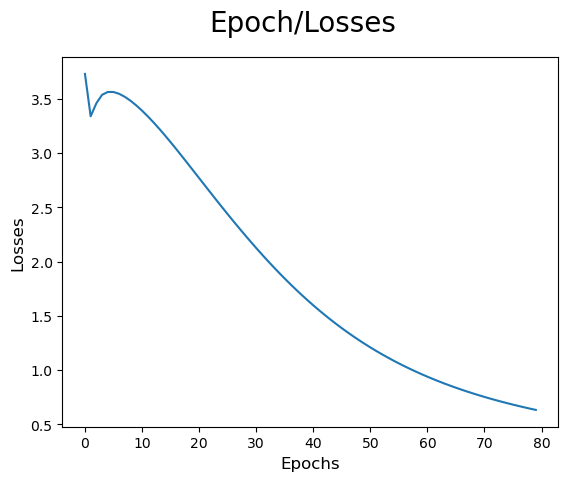

In [33]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [35]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]

    return word

In [36]:
import random
random_context = random.choice(test_context)
print(random_context)
#predict(['there', 'was', 'so', 'very'])
predict(random_context)

['fortunately', 'was', 'in', 'time']


'just'

Accuracy

In [38]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1

    return (1 - (wrong / len(data)))

In [39]:
accuracy()

0.9925373134328358